## 1. Import libraries

In [405]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Embedding
from tensorflow.keras.callbacks import Callback
# from tf_keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from transformers import TFBertForSequenceClassification, BertTokenizer

# Disable oneDNN optimizations to avoid potential minor numerical differences caused by floating-point round-off errors.
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Print versions to make sure everything is installed correctly
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Set random seed so our results are reproducible
tf.random.set_seed(42)
print("Setup complete!")

TensorFlow version: 2.19.0
GPU available: False
Setup complete!


## 2. Collect data

In [406]:
bike_rental_file_name = "bike_rental_reviews.csv"
df = pd.read_csv(bike_rental_file_name)
print(df.head(5))
print(df.shape)

                                         review_text sentiment
0  The entire process was easy, and the availabil...  positive
1  Standard rental process. The mobile app was ac...   neutral
2  One of the best bike rentals I’ve had. The mob...  positive
3  One of the best bike rentals I’ve had. The cus...  positive
4  Not worth the money. The seat comfort was a ma...  negative
(50000, 2)


## 3. Check the data

In [407]:
# Check null values
df.isnull().sum()

review_text    0
sentiment      0
dtype: int64

In [408]:
# Check duplicates
df.duplicated().sum()

49700

In [409]:
# Remove duplicates
df = df.drop_duplicates()

In [410]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 0 to 1634
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  300 non-null    object
 1   sentiment    300 non-null    object
dtypes: object(2)
memory usage: 7.0+ KB


In [411]:
df.shape

(300, 2)

In [412]:
df['sentiment'].value_counts()

sentiment
positive    100
neutral     100
negative    100
Name: count, dtype: int64

## The dataset has 50000 records, 49700 are duplicate. Only 300 records left after removal of duplicates.

## The data is well balanced (100 records for each sentiment class) but we''ll add synthetic data to augment the volume of data

## 4. Add synthetic data

In [413]:
# Adding 3000 reviews generated from the internet
bike_rental_file_name_updated = "bike_rental_reviews_augmented_unique.csv"
df = pd.read_csv("bike_rental_reviews_augmented_unique.csv", encoding="latin1")
# Check null values
print('Checking null values:')
print(df.isnull().sum())
# Check duplicates
print('Checking duplicates:')
print(df.duplicated().sum())
print('Shape:')
print(df.shape)
print(df.info())
df['sentiment'].value_counts()

Checking null values:
review_text    0
sentiment      0
dtype: int64
Checking duplicates:
0
Shape:
(3300, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  3300 non-null   object
 1   sentiment    3300 non-null   object
dtypes: object(2)
memory usage: 51.7+ KB
None


sentiment
positive    1100
neutral     1100
negative    1100
Name: count, dtype: int64

## The data set now has a total of 3300 unique reviews and is well balanced: 1100 positive, 1100 negative, and 1100 neutral.

## 5. Preprocessing functions

In [414]:
# Function to convert text to lowercase
def convert_to_lowercase(text):
    text = text.lower() # convert to lowercase
    return text

# Function to remove numbers
def remove_numbers(text):
    text = re.sub(r'\d+', '', text)  # remove numbers
    return text

# Function to remove stopwords
stop_words = set(stopwords.words('english'))
sentiment_words = {'not', 'no', 'never', 'very', 'really', 'extremely'}
stop_words = stop_words - sentiment_words
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)
    return text

# Function to remove punctuation
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text) # 
    return text

# Function to remove extra spaces
def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text) # replace multiple spaces with a single space
    text = text.strip() # remove leading and trailing spaces
    return text

# Function to convert Penn Treebank tags to WordNet tags
def convert_pos_tag(penn_tag):
    if penn_tag.startswith('J'):
        return wordnet.ADJ
    elif penn_tag.startswith('V'):
        return wordnet.VERB
    elif penn_tag.startswith('N'):
        return wordnet.NOUN
    elif penn_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
# Function to lemmatize text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    lemmatized_text = []
    for word, tag in pos_tags:
        wordnet_tag = convert_pos_tag(tag)
        if wordnet_tag:
            lemmatized_word = lemmatizer.lemmatize(word, pos=wordnet_tag)
        else:
            lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_text.append(lemmatized_word)
    return lemmatized_text

# Define text preprocessing function
def preprocessing(text):
    text = convert_to_lowercase(text)
    text = remove_numbers(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = remove_extra_spaces(text)
    lemmatized_tokens = lemmatize_text(text)
    return lemmatized_tokens

In [415]:
sample_text = df['review_text'].iloc[0]
sample_text

'The entire process was easy, and the availability was high quality.'

## 6. Preprocess the text and convert to vector

In [416]:
df['lemmatized_tokens'] = df['review_text'].apply(preprocessing)
df['lemmatized_text'] = df['lemmatized_tokens'].apply(lambda x: ' '.join(x))
df.head(5)

,review_text,sentiment,lemmatized_tokens,lemmatized_text
0,"The entire process was easy, and the availabil...",positive,"[entire, process, easy, availability, high, qu...",entire process easy availability high quality
1,Standard rental process. The mobile app was ac...,neutral,"[standard, rental, process, mobile, app, accep...",standard rental process mobile app acceptable
2,One of the best bike rentals Iâve had. The m...,positive,"[one, best, bike, rental, iâve, have, mobile, ...",one best bike rental iâve have mobile app make...
3,One of the best bike rentals Iâve had. The c...,positive,"[one, best, bike, rental, iâve, have, customer...",one best bike rental iâve have customer servic...
4,Not worth the money. The seat comfort was a ma...,negative,"[not, worth, money, seat, comfort, major, letd...",not worth money seat comfort major letdown


In [417]:
#Embeddings
# Train Word2Vec on our data
sentences = df['lemmatized_tokens'].tolist()
embedding_dim = 64
w2v_model = Word2Vec(sentences, vector_size=embedding_dim, window=3, min_count=1, workers=1, seed=42)

def text_to_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

embeddings = np.array([text_to_vector(tokens, w2v_model) for tokens in df['lemmatized_tokens']])

In [418]:
embeddings

array([[ 0.0791572 ,  0.00644299,  0.2436767 , ...,  0.11822394,
        -0.00580738, -0.01396834],
       [ 0.07821969, -0.00380901,  0.24819218, ...,  0.11994804,
        -0.0169487 ,  0.02001074],
       [ 0.06419338, -0.00694769,  0.23291478, ...,  0.11963701,
        -0.01581222,  0.00864591],
       ...,
       [ 0.0492725 , -0.01980472,  0.23353224, ...,  0.11309376,
        -0.03661293,  0.0617983 ],
       [ 0.08781005,  0.00221789,  0.25528407, ...,  0.12215865,
        -0.02110055,  0.0416401 ],
       [ 0.04407817, -0.0291678 ,  0.2248771 , ...,  0.11114988,
        -0.03016918,  0.10235679]], dtype=float32)

## 7. Prepare the data and functions for modeling

### 7.1 Create X and y data

In [419]:
sentiments_map = {'negative': 0, 'neutral': 1, 'positive': 2}
X = embeddings
y = df['sentiment'].map(sentiments_map).values
print(y)

[2 1 2 ... 0 0 0]


### 7.2 Create train and test data

In [420]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [421]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2640, 64), (660, 64), (2640,), (660,))

### 7.3 Function to record the metrics


In [422]:
# Function to record the metrics of a multi-class classification model
def get_multiclass_classification_metrics(model, model_name, X_train, y_train, X_test, y_test):
   # Calculate probabilities
   y_train_pred_proba = model.predict_proba(X_train)
   y_test_pred_proba = model.predict_proba(X_test)

   # Predict classes
   y_train_pred = y_train_pred_proba.argmax(axis=1)
   y_test_pred = y_test_pred_proba.argmax(axis=1)

   # Calculate metrics
   accuracy_train = accuracy_score(y_train, y_train_pred)
   accuracy_test = accuracy_score(y_test, y_test_pred)
#    precision_train = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
#    precision_test = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
#    recall_train = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
#    recall_test = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
   f1_train = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
   f1_test = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

   # Confusion matrix and classification report for test data
   conf_matrix = confusion_matrix(y_test, y_test_pred, labels=model.classes_)
   class_report = classification_report(y_test, y_test_pred, labels=model.classes_)

   # Store all metrics in a dataframe with 4 decimal places
   metrics_df = pd.DataFrame([{
       "model_name": model_name,
       "train_accuracy": round(accuracy_train, 4),
       "test_accuracy": round(accuracy_test, 4),
    #    "train_precision": round(precision_train, 4),
    #    "test_precision": round(precision_test, 4),
    #    "train_recall": round(recall_train, 4),
    #    "test_recall": round(recall_test, 4),
       "train_f1": round(f1_train, 4),
       "test_f1": round(f1_test, 4)
   }])

   # Print the metrics
   print('Classification metrics of', model_name)
   print(metrics_df.T)
   print('\nConfusion Matrix of', model_name)
   print(conf_matrix)
   print('\nClassification Report of', model_name)
   print(class_report)

   return metrics_df

In [423]:
# Initiate classification metrics dataframe for all models that will be evaluated
classification_metrics_all_results = pd.DataFrame(columns=[
    "model_name",
    "train_accuracy",
    "test_accuracy",
    # "train_precision",
    # "test_precision",
    # "train_recall",
    # "test_recall",
    "train_f1",
    "test_f1"
])

### 7.4 Epoch Logging and Early Stopping functions

In [424]:
# Epoch logger callback
class EpochLogger(Callback):
    def __init__(self, interval=10):
        super().__init__()
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            log_str = f"Epoch {epoch + 1}: " + ", ".join(
                [f"{k}: {v:.4f}" for k, v in logs.items()]
            )
            print(log_str)

# Define early stopping callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

## 8. Logistic regression model

In [425]:
# Build Logistic Regression Model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)

In [426]:
# Train the Logistic Regression Model
log_reg_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [427]:
# Evaluate the Logistic Regression Model
log_reg_metrics_df = get_multiclass_classification_metrics(log_reg_model, "Logistic Regression", X_train, y_train, X_test, y_test)
classification_metrics_all_results = pd.concat([classification_metrics_all_results, log_reg_metrics_df], ignore_index=True)
classification_metrics_all_results

Classification metrics of Logistic Regression
                                  0
model_name      Logistic Regression
train_accuracy               0.9178
test_accuracy                0.8985
train_f1                     0.9185
test_f1                      0.8991

Confusion Matrix of Logistic Regression
[[205   0  15]
 [  8 184  25]
 [ 17   2 204]]

Classification Report of Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       220
           1       0.99      0.85      0.91       217
           2       0.84      0.91      0.87       223

    accuracy                           0.90       660
   macro avg       0.91      0.90      0.90       660
weighted avg       0.90      0.90      0.90       660



C:\Users\chris\AppData\Local\Temp\ipykernel_38232\812160816.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  classification_metrics_all_results = pd.concat([classification_metrics_all_results, log_reg_metrics_df], ignore_index=True)


,model_name,train_accuracy,test_accuracy,train_f1,test_f1
0,Logistic Regression,0.9178,0.8985,0.9185,0.8991


## 9. Naïve Bayes Model

In [428]:
# Build Naïve Bayes Model
naive_bayes_model = GaussianNB()

In [429]:
# Train Naïve Bayes Model
naive_bayes_model.fit(X_train, y_train)

GaussianNB()

In [430]:
# Evaluate the Naïve Bayes Model
naive_bayes_metrics_df = get_multiclass_classification_metrics(naive_bayes_model, "Naïve Bayes", X_train, y_train, X_test, y_test)
classification_metrics_all_results = pd.concat([classification_metrics_all_results, naive_bayes_metrics_df], ignore_index=True)
classification_metrics_all_results

Classification metrics of Naïve Bayes
                          0
model_name      Naïve Bayes
train_accuracy       0.8761
test_accuracy        0.8636
train_f1             0.8753
test_f1              0.8633

Confusion Matrix of Naïve Bayes
[[174  17  29]
 [  8 183  26]
 [  7   3 213]]

Classification Report of Naïve Bayes
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       220
           1       0.90      0.84      0.87       217
           2       0.79      0.96      0.87       223

    accuracy                           0.86       660
   macro avg       0.87      0.86      0.86       660
weighted avg       0.87      0.86      0.86       660



,model_name,train_accuracy,test_accuracy,train_f1,test_f1
0,Logistic Regression,0.9178,0.8985,0.9185,0.8991
1,Naïve Bayes,0.8761,0.8636,0.8753,0.8633


## 10. LSTM Model

### 10.1 Build and configure LSTM model

In [431]:
# Build LSTM model
number_of_classes = len(np.unique(y))
vocab_size = 5000  # Adjust based on your dataset
lstm_model = Sequential(
    [
        Embedding(vocab_size, embedding_dim),
        Bidirectional(LSTM(embedding_dim)),
        Dense(embedding_dim, activation='relu'),
        Dense(number_of_classes, activation='softmax')
    ]
)

In [432]:
lstm_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [433]:
lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

### 10.2 Train LSTM model

In [434]:
# Train the model
lstm_model_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    validation_split=0.2,
    verbose=0,
    callbacks=[EpochLogger(interval=5)]
)

Epoch 5: accuracy: 0.3362, loss: 1.0989, val_accuracy: 0.3144, val_loss: 1.0990
Epoch 10: accuracy: 0.3381, loss: 1.0988, val_accuracy: 0.3144, val_loss: 1.0991
Epoch 15: accuracy: 0.3310, loss: 1.0990, val_accuracy: 0.3144, val_loss: 1.0989
Epoch 20: accuracy: 0.3381, loss: 1.0987, val_accuracy: 0.3144, val_loss: 1.0991
Epoch 25: accuracy: 0.3295, loss: 1.0988, val_accuracy: 0.3144, val_loss: 1.0992
Epoch 30: accuracy: 0.3381, loss: 1.0986, val_accuracy: 0.3144, val_loss: 1.0991
Epoch 35: accuracy: 0.3381, loss: 1.0986, val_accuracy: 0.3144, val_loss: 1.0991
Epoch 40: accuracy: 0.3381, loss: 1.0987, val_accuracy: 0.3144, val_loss: 1.0991
Epoch 45: accuracy: 0.3381, loss: 1.0986, val_accuracy: 0.3144, val_loss: 1.0991
Epoch 50: accuracy: 0.3381, loss: 1.0986, val_accuracy: 0.3144, val_loss: 1.0991


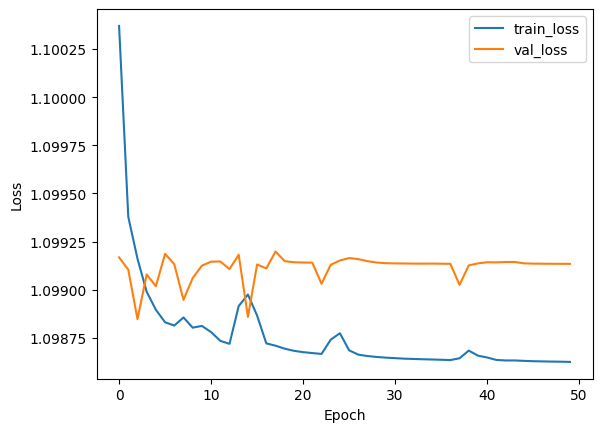

In [435]:
# Plot training history
plt.plot(lstm_model_history.history['loss'], label='train_loss')
plt.plot(lstm_model_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 10.3 Test LSTM model and calculate performance metrics

In [436]:
# Predict probabilities
y_train_lstm_pred_prob = lstm_model.predict(X_train)
y_test_lstm_pred_prob = lstm_model.predict(X_test)

# Predict labels
y_train_lstm_pred = np.argmax(y_train_lstm_pred_prob, axis=1)
y_test_lstm_pred = np.argmax(y_test_lstm_pred_prob, axis=1)

# Calculate accuracy and f1 score
lstm_model_train_accuracy = accuracy_score(y_train, y_train_lstm_pred)
lstm_model_test_accuracy = accuracy_score(y_test, y_test_lstm_pred)
lstm_model_train_f1 = f1_score(y_train, y_train_lstm_pred, average='weighted')
lstm_model_test_f1 = f1_score(y_test, y_test_lstm_pred, average='weighted')

print(f"Train Accuracy: {lstm_model_train_accuracy:.4f}, Train F1 Score: {lstm_model_train_f1:.4f}")
print(f"Test Accuracy: {lstm_model_test_accuracy:.4f}, Test F1 Score: {lstm_model_test_f1:.4f}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Train Accuracy: 0.3333, Train F1 Score: 0.1667
Test Accuracy: 0.3333, Test F1 Score: 0.1667


In [437]:
lstm_model_metrics_df = pd.DataFrame([{
    'model_name': 'LSTM',
    'train_accuracy': lstm_model_train_accuracy,
    'test_accuracy': lstm_model_test_accuracy,
    'train_f1': lstm_model_train_f1,
    'test_f1': lstm_model_test_f1
}])
classification_metrics_all_results = pd.concat([classification_metrics_all_results, lstm_model_metrics_df], ignore_index=True)
classification_metrics_all_results

,model_name,train_accuracy,test_accuracy,train_f1,test_f1
0,Logistic Regression,0.917800,0.898500,0.918500,0.899100
1,Naïve Bayes,0.876100,0.863600,0.875300,0.863300
2,LSTM,0.333333,0.333333,0.166667,0.166667


## 11. BERT model

### 11.1 Load pre-trained BERT model and tokenizer

In [438]:
# Define our model configuration
model_name = 'bert-base-uncased'    # Use base BERT model (uncased = lowercase)
max_length = 64                     # Maximum number of tokens per review
num_labels = len(np.unique(y))

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

# Load the pre-trained BERT model for classification
bert_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# test the tokenizer with a sample review_text
sample_review_text = df['review_text'].iloc[0]
print('Sample review text:', sample_review_text)
tokens = tokenizer.encode(sample_review_text, max_length=max_length, padding='max_length', truncation=True)
print('Tokens:', tokens)
decoded_text = tokenizer.decode(tokens, skip_special_tokens=True)
print('Decoded text:', decoded_text)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sample review text: The entire process was easy, and the availability was high quality.
Tokens: [101, 1996, 2972, 2832, 2001, 3733, 1010, 1998, 1996, 11343, 2001, 2152, 3737, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded text: the entire process was easy, and the availability was high quality.


### 11.2 Tokenize reviews and prepare training data

In [439]:
# Function to tokenize reviews
def tokenize_reviews(texts, labels, tokenizer, max_length):
    # Lists to store the processed data
    input_ids = []          # Token IDs for each review
    attention_masks = []    # Masks to ignore padding tokens

    # Process each review
    for text in texts:
        # Tokenize the text and prepare it for BERT
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,        # Add [CLS] at start, [SEP] at end
            max_length=max_length,          # Limit length to MAX_LENGTH
            padding='max_length',           # Pad shorter texts with zeros
            truncation=True,                # Cut off longer texts
            return_attention_mask=True,     # Create attention mask
            return_tensors='tf'             # Return TensorFlow tensors
        )

        # Store the tokenized data
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    # Convert lists to tensors
    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    labels_tensor = tf.constant(labels)

    return input_ids, attention_masks, labels_tensor

In [440]:
# Prepare training data and test data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review_text'].tolist(),
    y.tolist(),
    test_size=0.2,
    random_state=42)

In [441]:
# Tokenize the training and test data
train_input_ids, train_attention_masks, train_labels_tensor = tokenize_reviews(
    train_texts, train_labels, tokenizer, max_length)

test_input_ids, test_attention_masks, test_labels_tensor = tokenize_reviews(
    test_texts, test_labels, tokenizer, max_length)

print('test_input_ids:', test_input_ids)
print('test_attention_masks:', test_attention_masks)
print('test_labels_tensor:', test_labels_tensor)

test_input_ids: tf.Tensor(
[[  101  1996 18105 ...     0     0     0]
 [  101 11079  2134 ...     0     0     0]
 [  101 11079  2134 ...     0     0     0]
 ...
 [  101  4638  1029 ...     0     0     0]
 [  101  1996 11079 ...     0     0     0]
 [  101 12635  2001 ...     0     0     0]], shape=(660, 64), dtype=int32)
test_attention_masks: tf.Tensor(
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(660, 64), dtype=int32)
test_labels_tensor: tf.Tensor(
[1 0 0 2 2 1 0 1 2 2 2 0 2 1 1 0 2 0 2 2 2 0 1 0 1 1 2 2 2 1 2 0 1 2 0 2 0
 2 0 1 1 1 1 0 1 2 2 1 0 1 0 0 2 1 0 0 1 0 1 0 1 1 2 2 0 2 0 1 0 1 2 0 0 2
 2 2 2 2 1 1 2 1 0 0 1 1 1 1 2 0 2 2 0 2 2 0 2 2 1 2 0 2 2 1 2 0 1 1 0 2 0
 1 1 1 1 2 2 1 0 1 1 2 0 2 0 2 0 1 2 0 0 2 0 1 2 2 0 0 0 0 0 2 2 0 1 0 1 0
 0 2 0 0 0 0 1 0 1 1 0 0 2 1 1 1 0 2 2 1 0 2 1 2 2 0 2 0 1 2 0 0 2 0 1 1 0
 0 0 1 0 2 2 1 2 2 2 1 2 2 2 0 0 1 0 2 2 2 2 0 2 0 0 0 1 2 1 2 0 1 0 2 0 0
 0 1 1 0 1 1 

### 11.3 Set up and train our BERT model

In [442]:
# Configure and compile BERT model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)  # Use a small learning rate for fine-tuning
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
bert_model.compile(optimizer='adam', loss=loss_function, metrics=metrics)

In [443]:
# Prepare training data in the format BERT expects
# BERT needs both input_ids and attention_mask as input
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({
        'input_ids': train_input_ids,            # Token IDs
        'attention_mask': train_attention_masks  # Attention masks
    },
    train_labels_tensor)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    ({
        'input_ids': test_input_ids,
        'attention_mask': test_attention_masks
    },
    test_labels_tensor)
)

In [444]:
# Create batches for efficient training
batch_size = 4                  # Process 4 reviews at a time
train_dataset = train_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.batch(batch_size=batch_size)

In [445]:
# Train BERT model
bert_model_history = bert_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5,
    verbose=1
)

Epoch 1/5
660/660 [==============================] - 674s 999ms/step - loss: 1.2419 - accuracy: 0.3307 - val_loss: 1.1775 - val_accuracy: 0.3379
Epoch 2/5
660/660 [==============================] - 969s 1s/step - loss: 1.2342 - accuracy: 0.3348 - val_loss: 1.1870 - val_accuracy: 0.3379
Epoch 3/5
660/660 [==============================] - 521s 790ms/step - loss: 1.2303 - accuracy: 0.3383 - val_loss: 1.2043 - val_accuracy: 0.3379
Epoch 4/5
660/660 [==============================] - 566s 857ms/step - loss: 1.2385 - accuracy: 0.3375 - val_loss: 1.1559 - val_accuracy: 0.3379
Epoch 5/5
660/660 [==============================] - 599s 908ms/step - loss: 1.2226 - accuracy: 0.3364 - val_loss: 1.1323 - val_accuracy: 0.3379


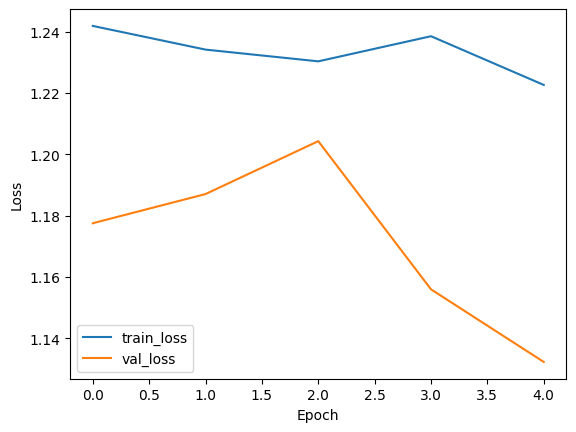

In [446]:
# Plot training history
plt.plot(bert_model_history.history['loss'], label='train_loss')
plt.plot(bert_model_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 11.4 Test BERT model and calculate performance metrics

In [447]:
# Predict probabilities
y_train_bert_pred_prob = bert_model.predict(train_dataset)
y_test_bert_pred_prob = bert_model.predict(test_dataset)

# Predict labels
y_train_bert_pred = np.argmax(y_train_bert_pred_prob.logits, axis=1)
y_test_bert_pred = np.argmax(y_test_bert_pred_prob.logits, axis=1)

# Calculate accuracy and f1 score
bert_model_train_accuracy = accuracy_score(y_train, y_train_bert_pred)
bert_model_test_accuracy = accuracy_score(y_test, y_test_bert_pred)
bert_model_train_f1 = f1_score(y_train, y_train_bert_pred, average='weighted')
bert_model_test_f1 = f1_score(y_test, y_test_bert_pred, average='weighted')

print(f"Train Accuracy: {bert_model_train_accuracy:.4f}, Train F1 Score: {bert_model_train_f1:.4f}")
print(f"Test Accuracy: {bert_model_test_accuracy:.4f}, Test F1 Score: {bert_model_test_f1:.4f}")

165/165 [==============================] - 36s 216ms/step
Train Accuracy: 0.3322, Train F1 Score: 0.1657
Test Accuracy: 0.3379, Test F1 Score: 0.1707


In [448]:
bert_model_metrics_df = pd.DataFrame([{
    'model_name': 'BERT',
    'train_accuracy': bert_model_train_accuracy,
    'test_accuracy': bert_model_test_accuracy,
    'train_f1': bert_model_train_f1,
    'test_f1': bert_model_test_f1
}])
classification_metrics_all_results = pd.concat([classification_metrics_all_results, bert_model_metrics_df], ignore_index=True)
classification_metrics_all_results

,model_name,train_accuracy,test_accuracy,train_f1,test_f1
0,Logistic Regression,0.917800,0.898500,0.918500,0.899100
1,Naïve Bayes,0.876100,0.863600,0.875300,0.863300
2,LSTM,0.333333,0.333333,0.166667,0.166667
3,BERT,0.332197,0.337879,0.165673,0.170661


## 12. README

### Bike Rental Reviews Sentiment Analysis  

#### Project Overview  
This project focuses on sentiment analysis of customer reviews for a bike rental service. The goal is to classify reviews into three categories: positive, neutral, or negative.  

The workflow involves:  
1. Importing and preparing data  
2. Cleaning and preprocessing text  
3. Converting text into numerical embeddings  
4. Training and evaluating multiple machine learning and deep learning models:  
   - Logistic Regression  
   - Naïve Bayes  
   - LSTM (Bidirectional)  
   - BERT (pretrained transformer)  

#### Dataset  
- Source file: `bike_rental_reviews.csv` (50,000 reviews)  
- After removing 49,700 duplicates, only 300 unique reviews remained (100 per sentiment class).  
- To address this, synthetic reviews were added using `bike_rental_reviews_augmented_unique.csv`, resulting in 3,300 balanced records:  
  - 1,100 positive  
  - 1,100 neutral  
  - 1,100 negative  
- Both CSV files must be placed in the working directory for the code to run properly.  

#### Preprocessing Steps  
The following text preprocessing functions were applied:  
- Convert to lowercase  
- Remove numbers  
- Remove stopwords (except key sentiment words: not, no, never, very, really, extremely)  
- Remove punctuation and extra spaces  
- Tokenization and Part-of-Speech tagging  
- Lemmatization with WordNet  

Text is then transformed into vectors using Word2Vec embeddings.  

#### Models Implemented  
##### 1. Logistic Regression  
- Achieved strong accuracy (~90%) and F1 score.  

##### 2. Naïve Bayes  
- Slightly lower performance (~86% accuracy), but effective as a simple baseline model.  

##### 3. LSTM (Bidirectional)  
- Configured with an embedding layer and bidirectional LSTM.  
- Results were poor (~33% accuracy), likely due to limited data and lack of optimized hyperparameters.  

##### 4. BERT (Transformers)  
- Fine-tuned with `bert-base-uncased`.  
- Accuracy remained low (~33%), suggesting more fine-tuning is required.  

#### Performance Summary  
| Model               | Train Accuracy | Test Accuracy | Train F1  | Test F1  |  
|----------------------|----------------|---------------|-----------|----------|  
| Logistic Regression  | 0.9178         | 0.8985        | 0.9185    | 0.8991   |  
| Naïve Bayes          | 0.8761         | 0.8636        | 0.8753    | 0.8633   |  
| LSTM                 | 0.3333         | 0.3333        | 0.1667    | 0.1667   |  
| BERT                 | 0.3322         | 0.3379        | 0.1657    | 0.1707   |  


#### How to run
Place the datasets (bike_rental_reviews.csv and bike_rental_reviews_augmented_unique.csv) in your working directory.

Run the Python script or Jupyter Notebook.

The script will:

Load and preprocess data

Train models

Output evaluation metrics (accuracy, F1 score, confusion matrix, classification report)

#### Conclusion
Among all tested models, Logistic Regression performed the best, with a test accuracy of approximately 89.9% and F1 score of 0.8991. Naïve Bayes followed closely with a test accuracy of 86.4% and F1 score of 0.8633. LSTM and BERT underperformed significantly on this dataset.